1. Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;
2. Сделать базовый анализ целевой переменной, сделать выводы;
3. Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;
4. Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;
5. Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?
6. Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.
7. Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.


In [29]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("/content/drive/My Drive/assignment1_data/train.csv")
test = pd.read_csv("/content/drive/My Drive/assignment1_data/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [5]:
train.describe()

target          var_0  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean        0.100490      10.679914  ...      15.870720      -3.326537
std         0.300653       3.040051  ...       3.010945      10.438015
min         0.000000       0.408400  ...       6.299300     -38.852800
25%         0.000000       8.453850  ...      13.829700     -11.208475
50%         0.000000      10.524750  ...      15.934050      -2.819550
75%         0.000000      12.758200  ...      18.064725       4.836800
max         1.000000      20.315000  ...      26.079100      28.500700

[8 rows x 201 columns]

In [6]:
test.describe()

var_0          var_1  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean       10.658737      -1.624244  ...      15.869184      -3.246342
std         3.036716       4.040509  ...       3.008717      10.398589
min         0.188700     -15.043400  ...       6.584000     -39.457800
25%         8.442975      -4.700125  ...      13.847275     -11.124000
50%        10.513800      -1.590500  ...      15.943400      -2.725950
75%        12.739600       1.343400  ...      18.045200       4.935400
max        22.323400       9.385100  ...      26.538400      27.907400

[8 rows x 200 columns]

In [7]:
train.tail()

ID_code  target    var_0  ...  var_197  var_198  var_199
199995  train_199995       0  11.4880  ...   8.5326  16.6660 -17.8661
199996  train_199996       0   4.9149  ...   6.7419  15.9054   0.3388
199997  train_199997       0  11.2232  ...   8.7155  13.8329   4.1995
199998  train_199998       0   9.7148  ...  10.0342  15.5289 -13.9001
199999  train_199999       0  10.8762  ...   8.1857  12.1284   0.1385

[5 rows x 202 columns]

In [8]:
test.tail()

ID_code    var_0   var_1  ...  var_197  var_198  var_199
199995  test_199995  13.1678  1.0136  ...   9.1568  18.2102   4.8801
199996  test_199996   9.7171 -9.1462  ...   9.1112  18.1740 -20.7689
199997  test_199997  11.6360  2.2769  ...   9.1933  11.7905 -22.2762
199998  test_199998  13.5745 -0.5134  ...   8.1079   8.7735  -0.2122
199999  test_199999  10.4664  1.8070  ...  10.3378  14.3340  -7.7094

[5 rows x 201 columns]

In [9]:
train.isnull().values.sum()

0

In [10]:
test.isnull().values.sum()

0

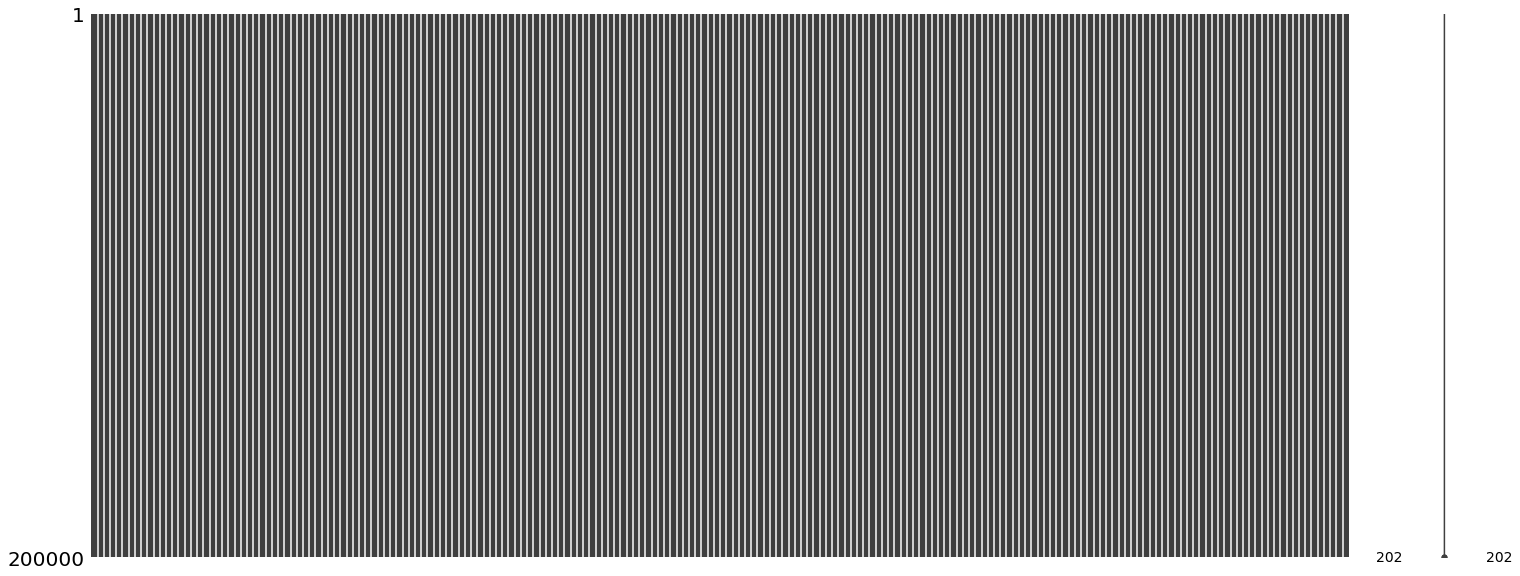

In [11]:
msno.matrix(train)

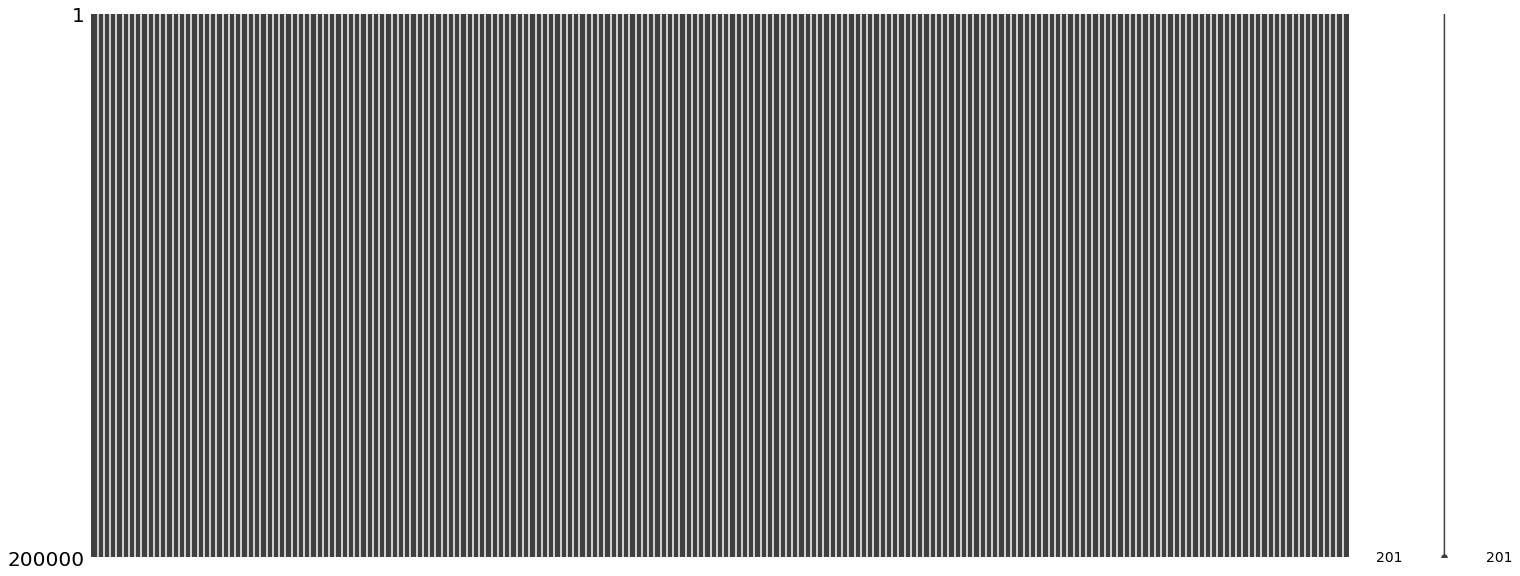

In [12]:

msno.matrix(test)

пропуски отсутствуют

In [13]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [14]:
numerical_features.head(n=2)

target    var_0   var_1    var_2  ...  var_196  var_197  var_198  var_199
0       0   8.9255 -6.7863  11.9081  ...   7.8784   8.5635  12.7803  -1.0914
1       0  11.5006 -4.1473  13.8588  ...   8.1267   8.7889  18.3560   1.9518

[2 rows x 201 columns]

## Дескретные признаки

In [15]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature not in ["ID_code"]+["Id"]+["target"]
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 0


## Непрерывные признаки

In [16]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in  ["target"]]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


Целевая переменная у нас лежит в диапазоне от 0 до 1, все признаки непрерывные численные.

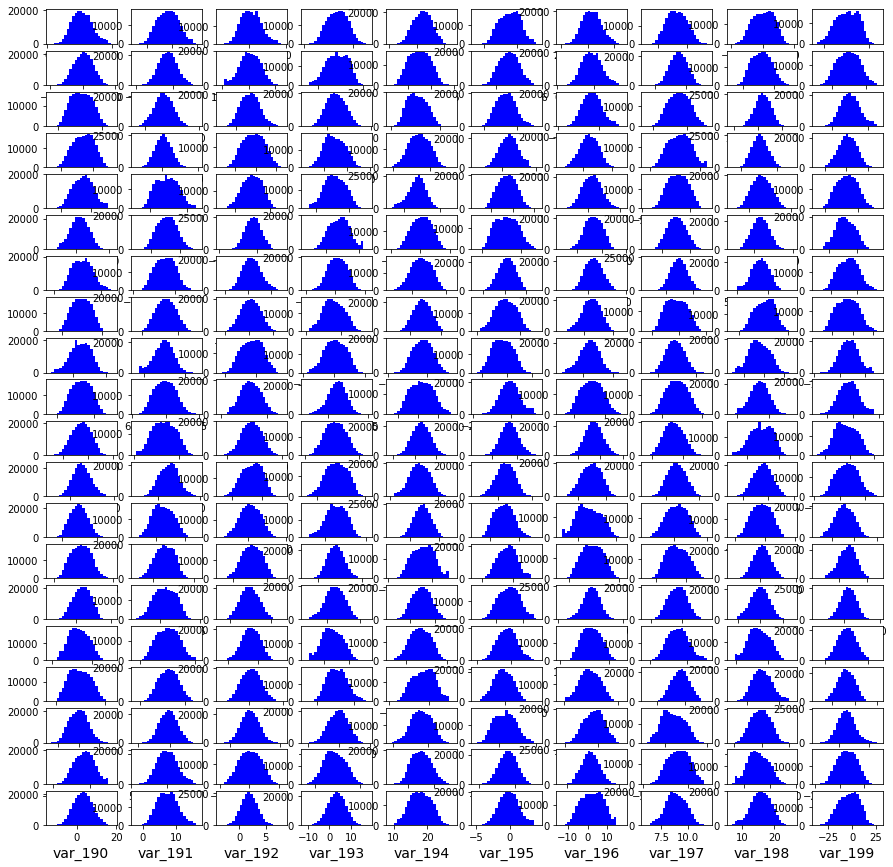

In [17]:
fig, axes = plt.subplots(20, 10, figsize=(15, 15))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    axes[num//10, num%10].hist(data, bins=25, color="blue")
    axes[num//10, num%10].set_xlabel(feature, fontsize=14)

похоже на нормально распределение, но смущают некоторые хвосты, нужно смотреть, это из-за выбросов или распределение иное

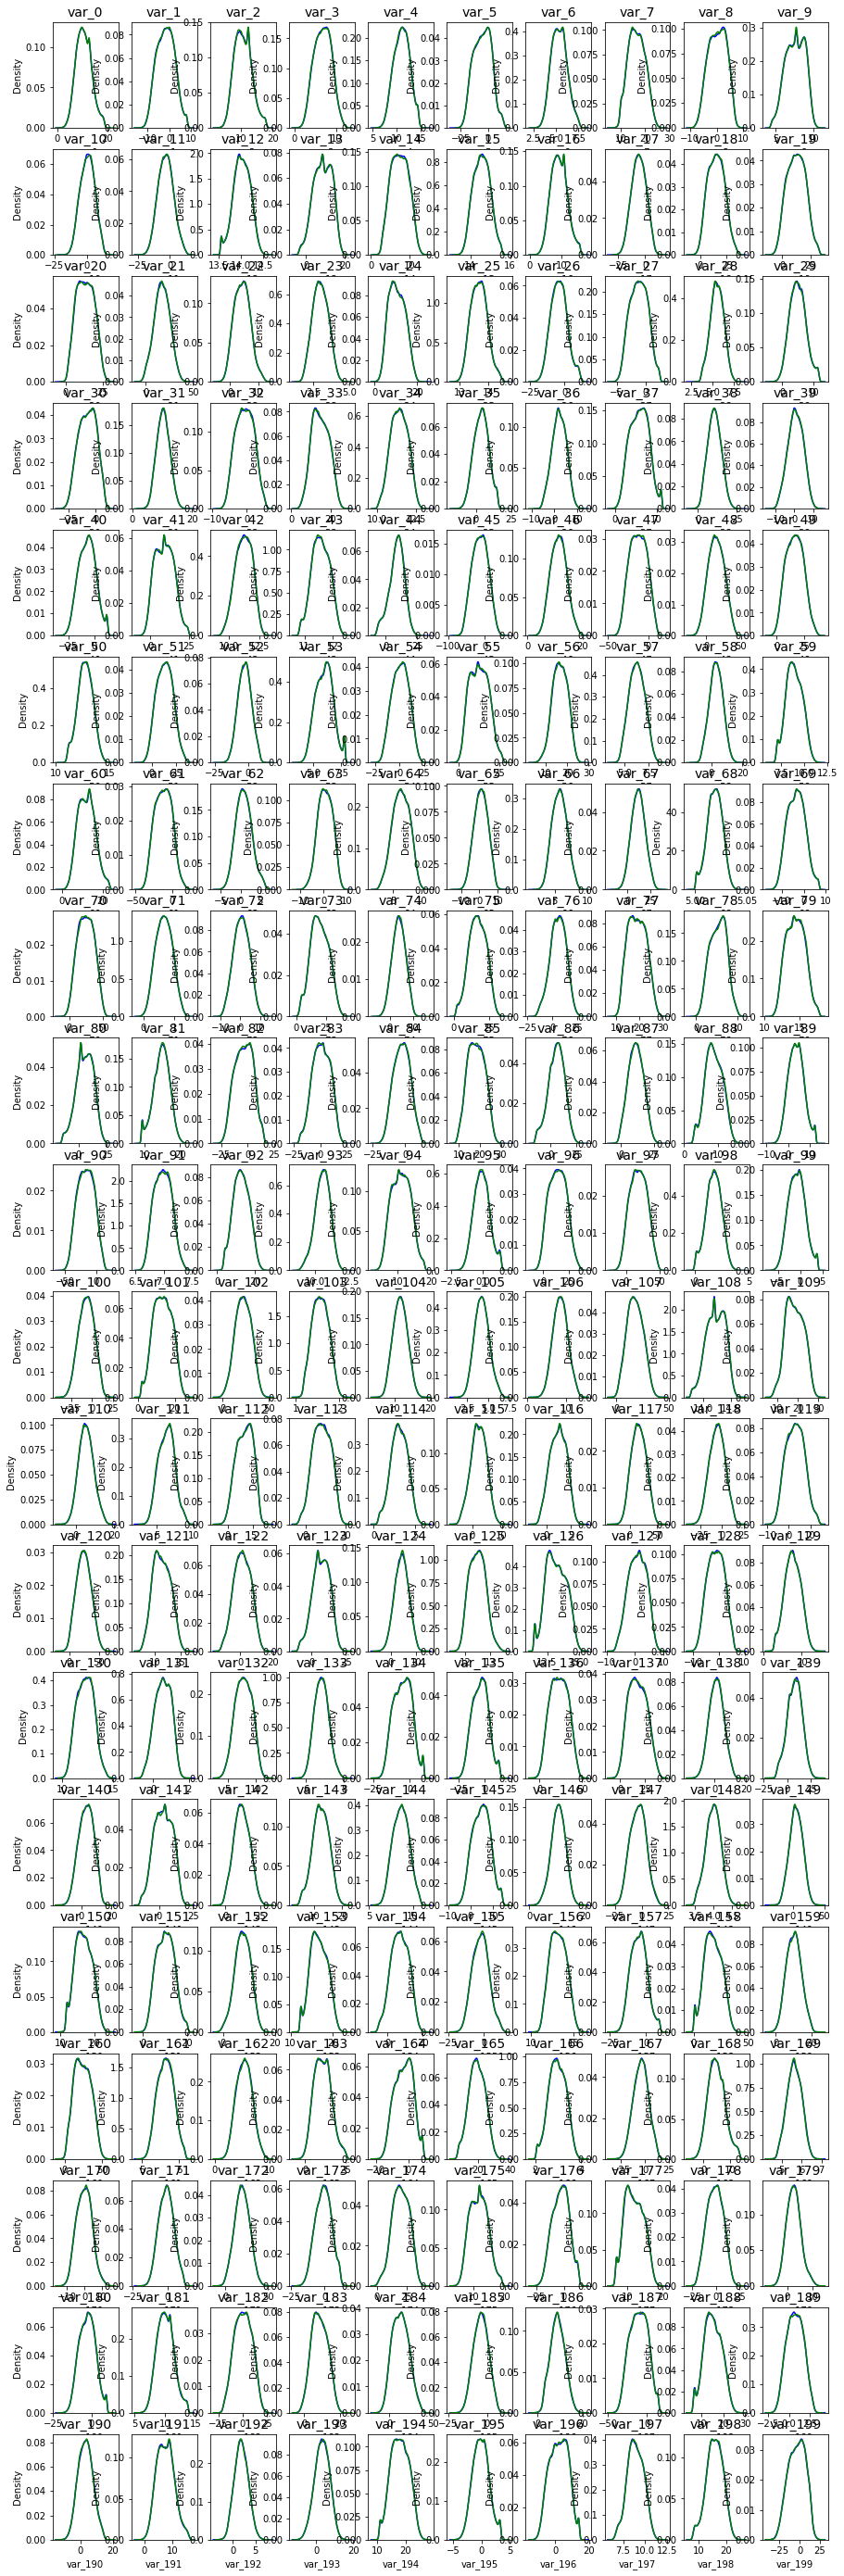

In [18]:
fig, axes = plt.subplots(20, 10, figsize=(15, 50))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//10, num%10], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//10, num%10], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//10, num%10], color="blue", label="train")
    axes[num//10, num%10].set_title(feature, fontsize=14)

распределение на трэйне и тесте идентично

## Анализ распределения целевой переменной

__Вывод:__ очевидно, что целевая переменная не распределена по нормальному распределению, поэтому перед построением модели регрессии, необходимо преобразовать целевую переменную. По графику видно, что Log-нормальное распределение близко к распределению целевой переменной, но больше подходит распределение Джонсона.

In [19]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


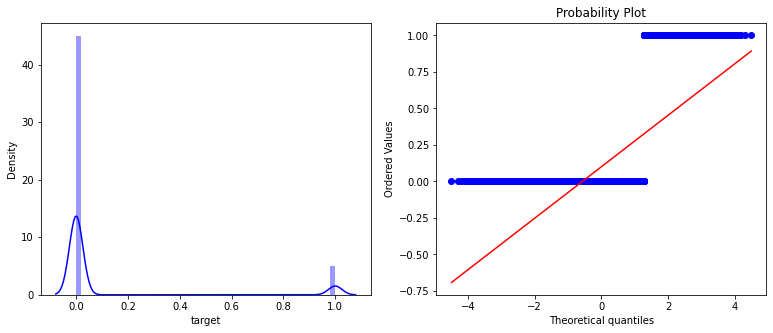

In [20]:
target = train['target']
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(target, color="blue")
plt.subplot(122)
probplot(target, plot=plt)
plt.show()

целевой признак бинарный и несбалансированный, стоит увеличить колличетсво данных по 1, либо уменьшить по 0

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

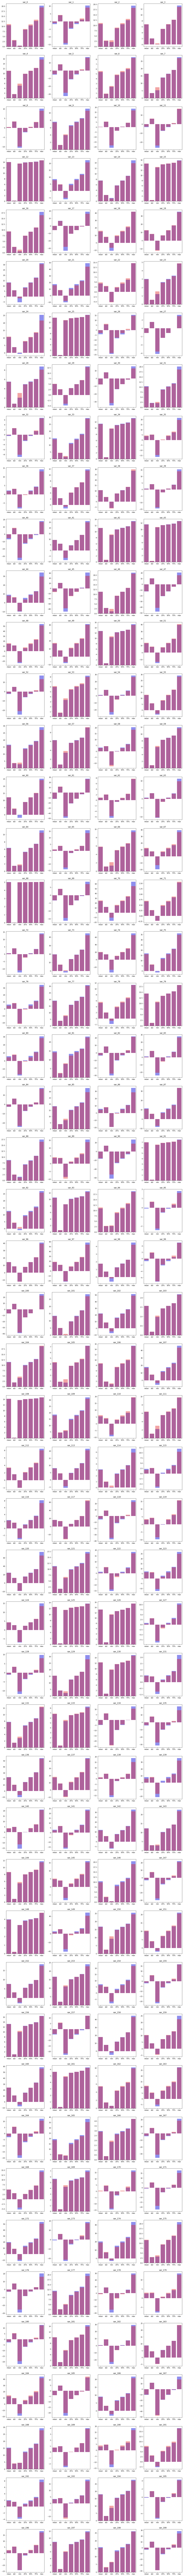

In [28]:
plt.figure(figsize=(20, 300))

for num, feature in enumerate(continuous_feature):
    plt.subplot(50, 4, num + 1)
    plt.title(feature)
    
    train_stat_t0 = train.loc[train["target"] == 0, feature].describe().drop('count', axis=0)
    train_stat_t1 = train.loc[train["target"] == 1, feature].describe().drop('count', axis=0)
    
    sns.barplot(train_stat_t0.index, train_stat_t0.values, alpha=0.5, color='b')
    sns.barplot(train_stat_t1.index, train_stat_t1.values, alpha=0.4, color='r')
    
plt.show()

различия есть, пример var24 но тут появляется вопрос того, насколько большие различия допустимы

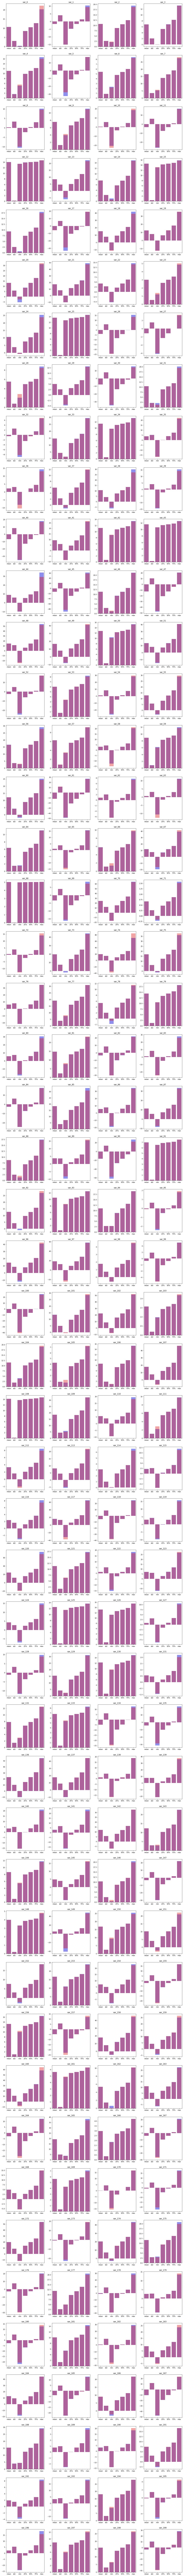

In [30]:
plt.figure(figsize=(20,300))

for num, feature in enumerate(continuous_feature):
    plt.subplot(50, 4, num+1)
    plt.title(feature)
    
    train_stat = train[feature].describe().drop('count', axis=0)
    test_stat = test[feature].describe().drop('count', axis=0)
    
    sns.barplot(train_stat.index, train_stat.values, alpha=0.5, color='b')
    sns.barplot(test_stat.index, test_stat.values, alpha=0.4, color='r')
    
plt.show()

нужна обработка от выбросов, явные расхождения в хвостах

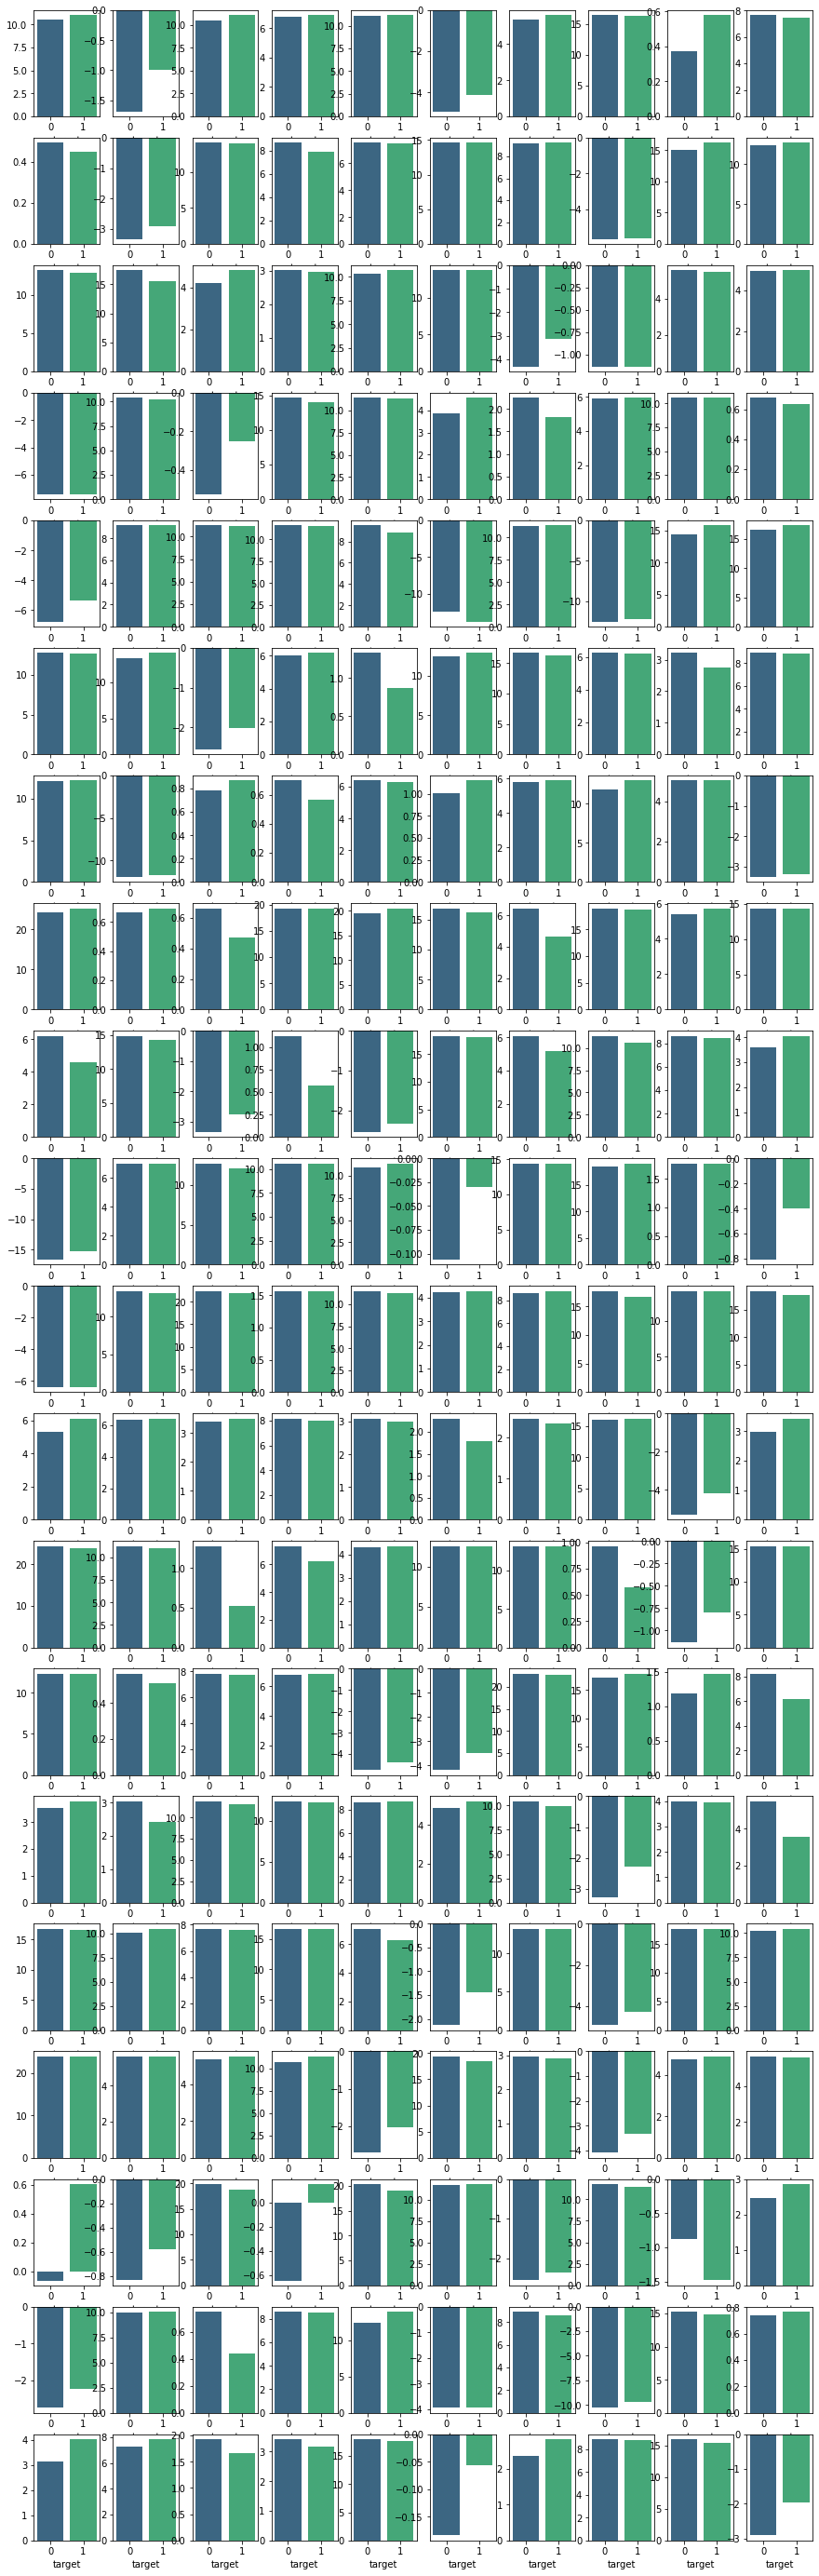

In [21]:
fig, axes = plt.subplots(20, 10, figsize=(15, 50))

for num, feature in enumerate(continuous_feature):
    data = train.copy()
    statistics = data.groupby(["target"])[feature].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num//10, num%10]
    )

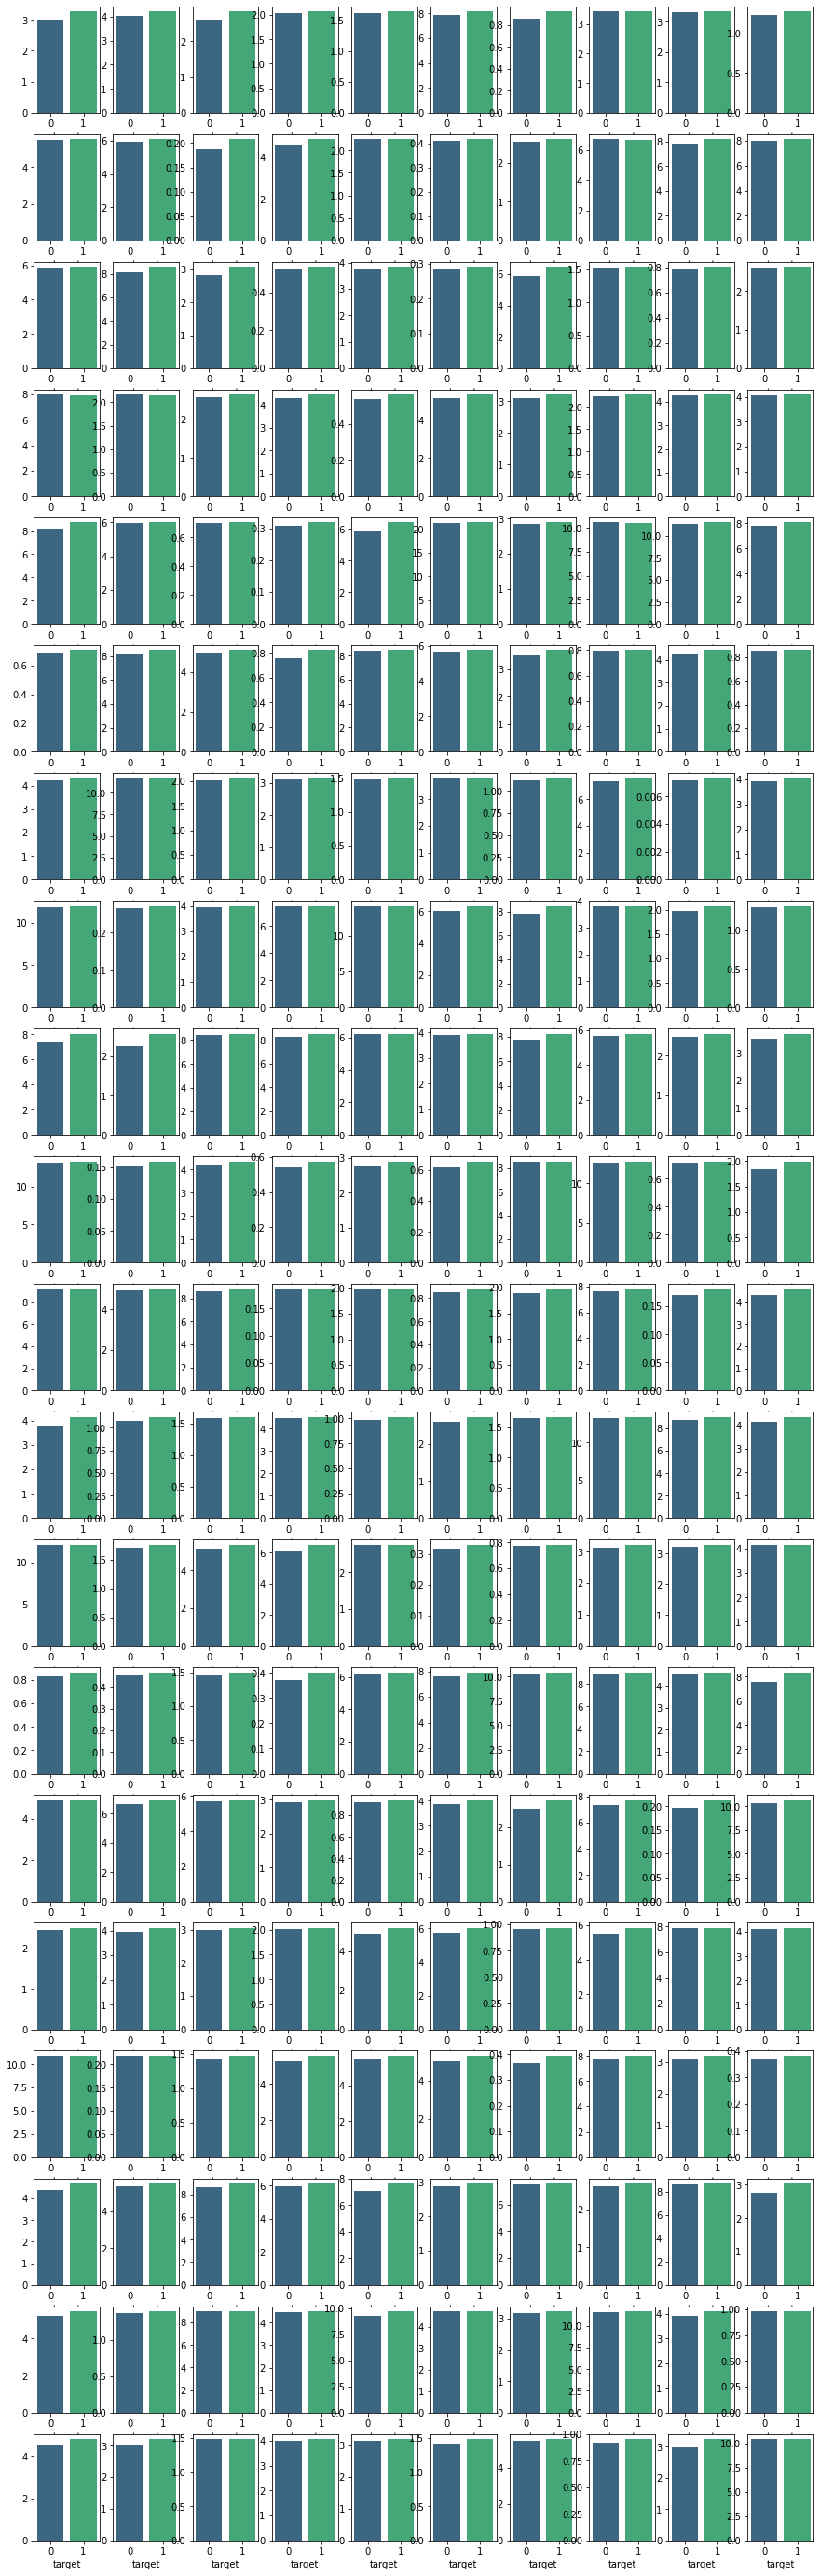

In [22]:

fig, axes = plt.subplots(20, 10, figsize=(15, 50))

for num, feature in enumerate(continuous_feature):
    data = train.copy()
    statistics = data.groupby(["target"])[feature].std()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num//10, num%10]
    )

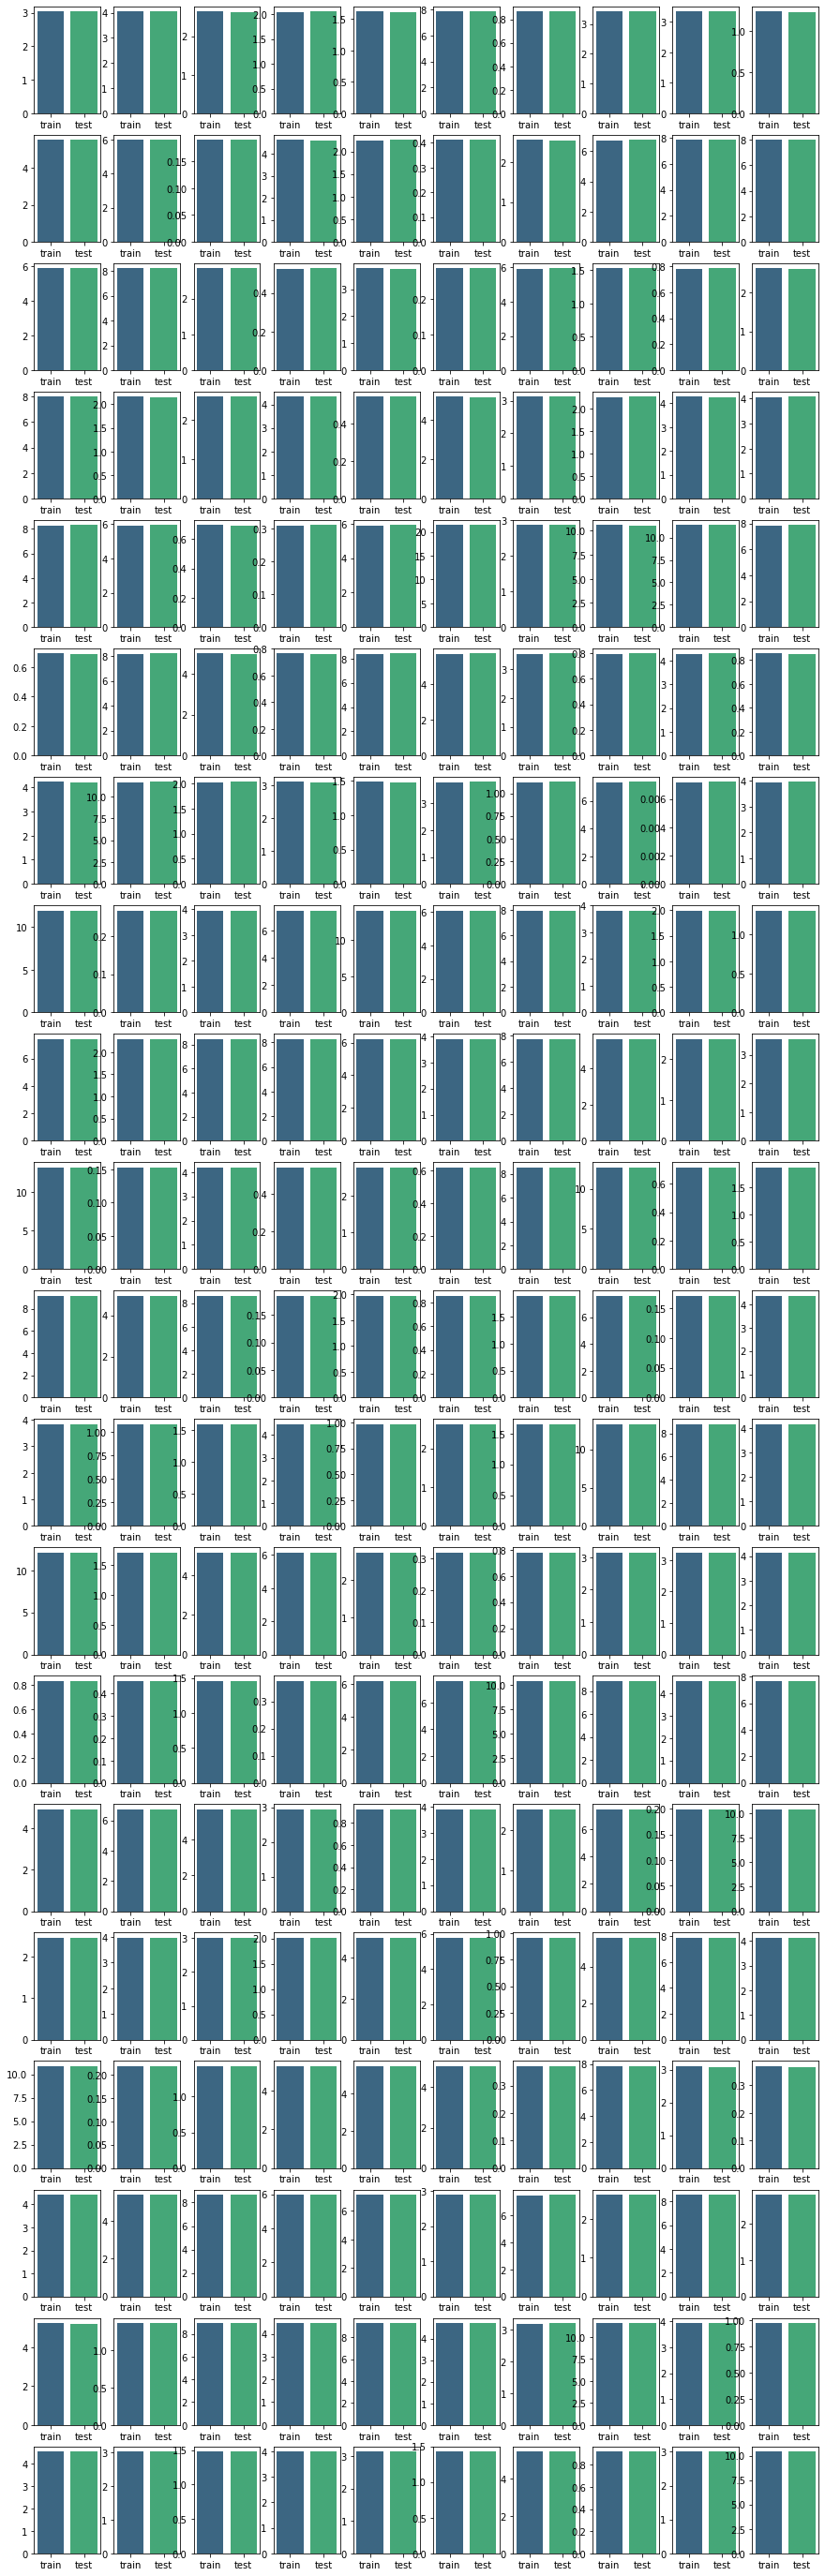

In [23]:
fig, axes = plt.subplots(20, 10, figsize=(15, 50))

for num, feature in enumerate(continuous_feature):

    sns.barplot(
        x=['train', 'test'],
        y=[train[feature].std(), test[feature].std()],
        palette="viridis",
        ax=axes[num//10, num%10]
    )

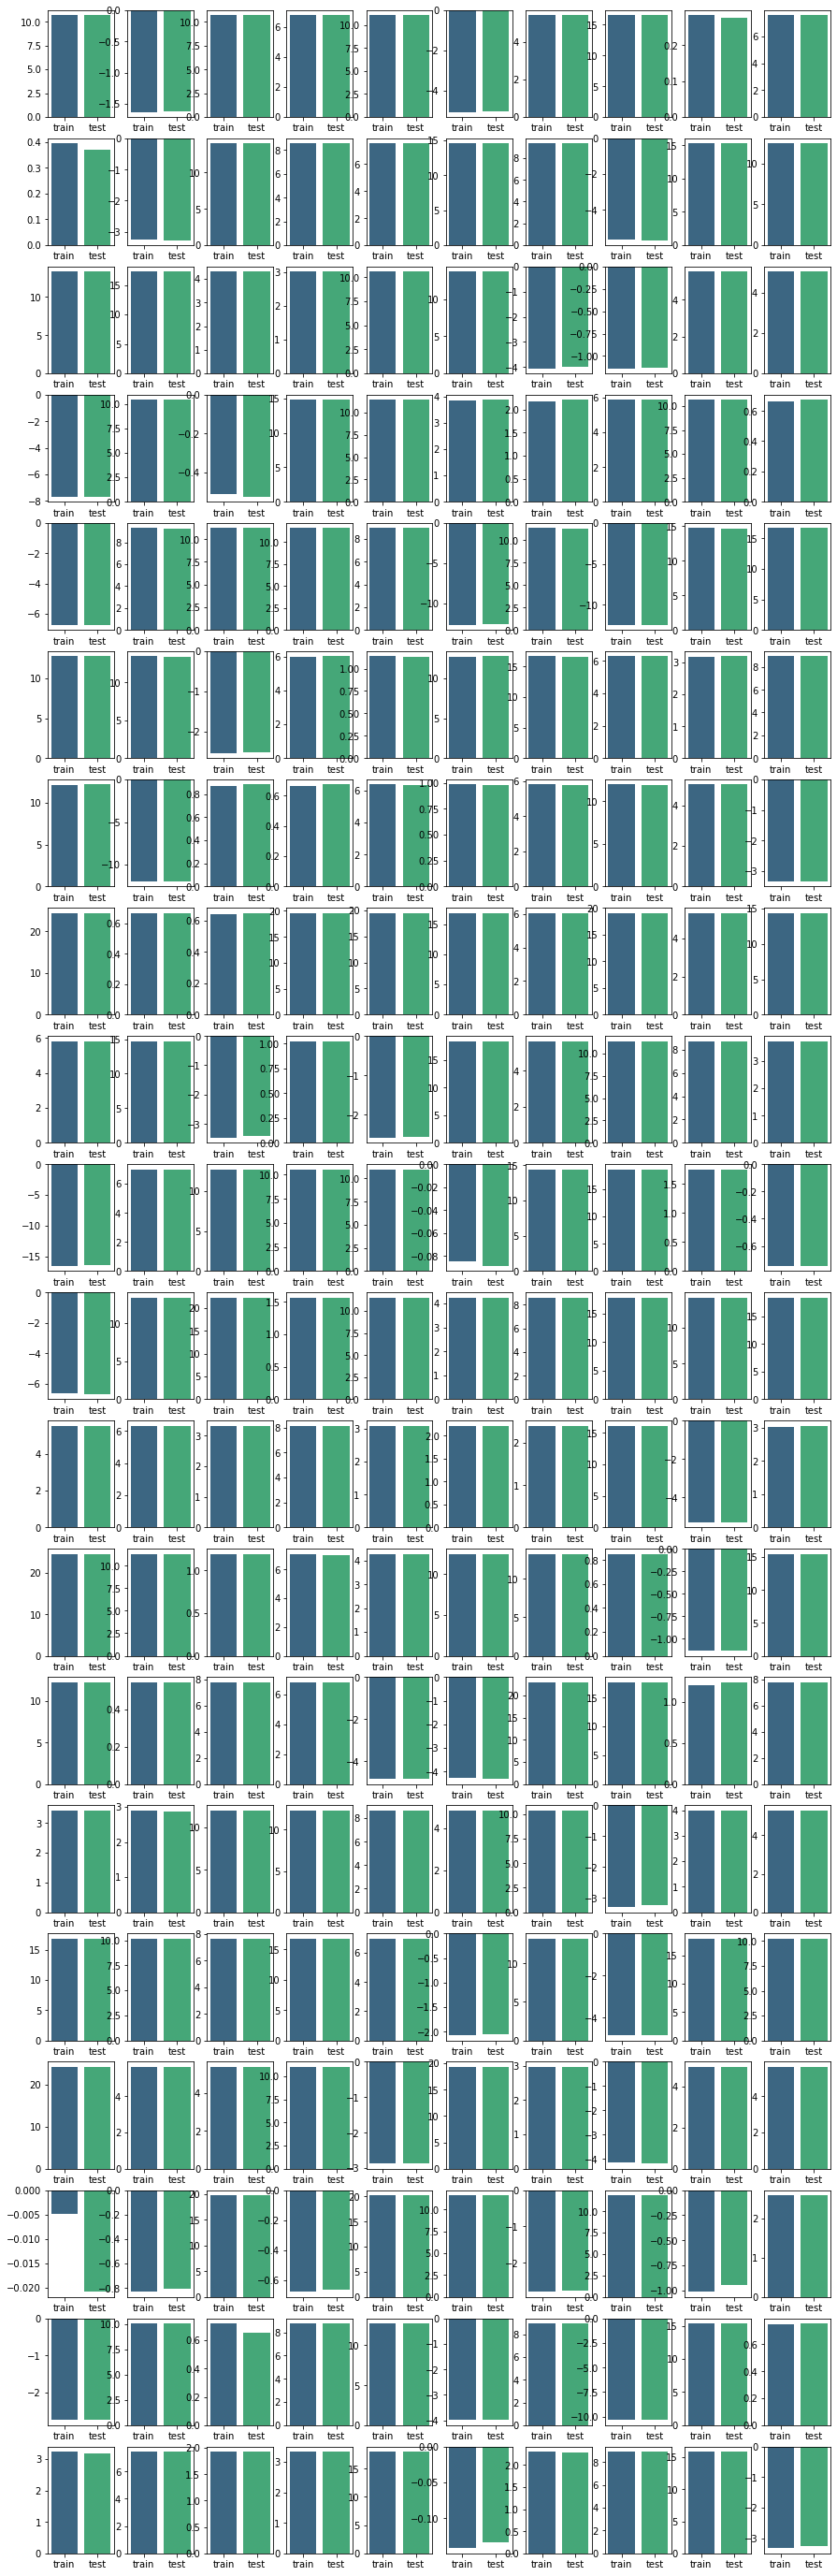

In [24]:
fig, axes = plt.subplots(20, 10, figsize=(15, 50))

for num, feature in enumerate(continuous_feature):

    sns.barplot(
        x=['train', 'test'],
        y=[train[feature].mean(), test[feature].mean()],
        palette="viridis",
        ax=axes[num//10, num%10]
    )

виден признак с явным различием между трейном и тестом, возможно его стоит исключить, также стоит обратить внимание на медиану целевого признака

## Корреляция между числовыми признаками

In [25]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target.head()

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
Name: target, dtype: float64

In [26]:

corr_with_target.head(25)

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
var_1      0.050343
var_179    0.050002
var_40     0.049530
var_184    0.048315
var_78     0.048245
var_170    0.047973
var_191    0.047114
var_94     0.046296
var_67     0.044673
var_18     0.043479
var_173    0.042022
var_164    0.040997
var_118    0.040358
var_147    0.040280
Name: target, dtype: float64

In [27]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

In [31]:
correlation = abs(train[continuous_feature].corr()) > 0.2

plt.figure(figsize=(20,15))

sns.set(font_scale=1.4)
sns.heatmap(train[continuous_feature].corr()[correlation], annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляция числовых признаков с целевой переменной')
plt.show()

корреляции между признаками нет

In [34]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.fillna(-9999).drop("target", axis=1), target)

CPU times: user 12min 39s, sys: 335 ms, total: 12min 39s
Wall time: 6min 35s


forest = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=2, oob_score=False,
                      random_state=27, verbose=0, warm_start=False)
forest.fit(numerical_features.fillna(-9999), target)

Text(0.5, 1.0, 'What are the top important features to start with?')

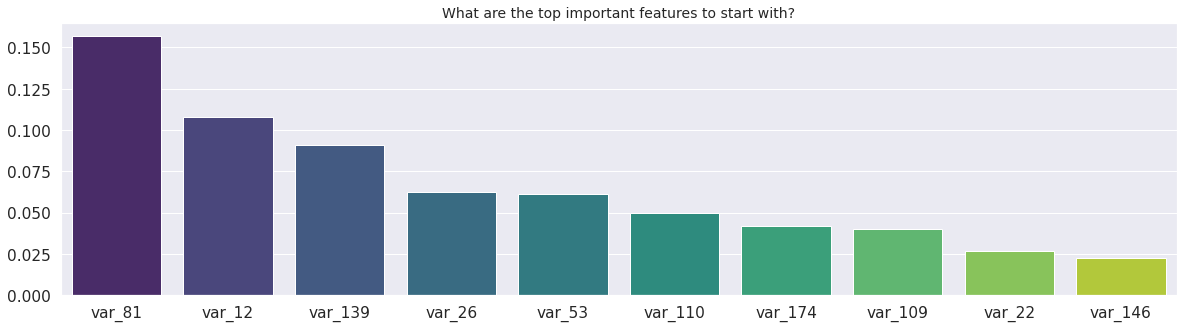

In [35]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

Найдены признаки с нелинейной связью

## Анализ распределения на обучении и тесте

Совпадение распределений на выборке для обучения и для тестирования - одна из ключевых коцепций статистического обучения. Обучая модель на некоторых данных, мы принимаем гипотезу о том, что модель должна работать на таких же данных.

## Kolmogorov-Smirnov Test

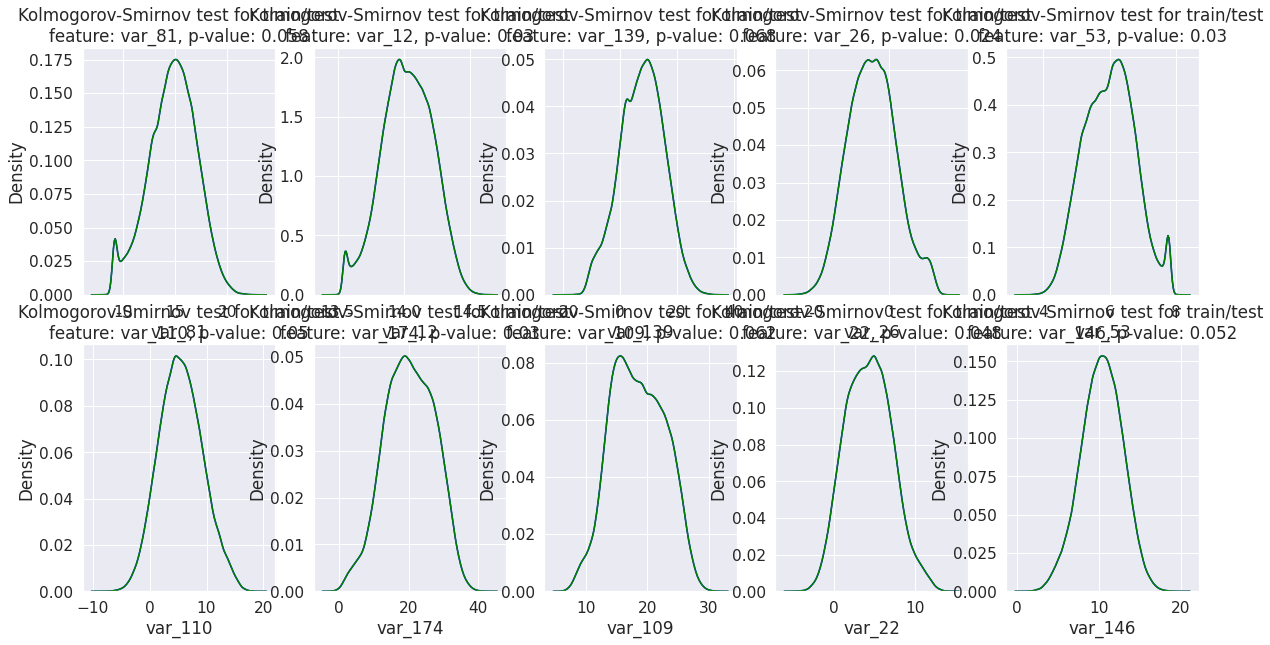

In [36]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(feature_names[idx]):
    statistic, pvalue = ks_2samp(
        train[feature[:50]].sample(500), test[feature[:50]].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

## Population Stability Index

In [37]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            self.calculate_psi_in_bin(exp_score, act_score)
            for exp_score, act_score in zip(expected_score, actual_score)
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

In [38]:
features_to_score = numerical_features.drop(["target"], axis=1).columns.tolist()
psi = PSI(threshold=0.01)

In [39]:
psi.fit_transform(
    X=train[features_to_score],
    y=test[features_to_score]
)

100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


Variable       PSI  Selected
0    var_154  0.000085         1
1    var_156  0.000132         1
2      var_5  0.000138         1
3    var_148  0.000150         1
4     var_35  0.000151         1
..       ...       ...       ...
195  var_124  0.000615         1
196   var_79  0.000628         1
197  var_162  0.000639         1
198   var_29  0.000667         1
199   var_90  0.000694         1

[200 rows x 3 columns]

Все признаки пригодны для дальнейшего обучения, распределения схожи